## 1.1)

In [2]:
s = "The quick brown fox jumps over the lazy dog"

print("with NLTK:")
from nltk import word_tokenize, pos_tag
from nltk import RegexpParser

tokens = word_tokenize(s)
pos_tags = pos_tag(tokens, tagset='universal')
NP_grammar = """
    NP: {<DET>?<ADJ>*<NOUN>+}
"""
chunker = RegexpParser(NP_grammar)
for subtree in chunker.parse(pos_tags).subtrees():
    if subtree.label() == "NP":
        print(subtree.leaves())

print("With spaCy:")
import spacy
from spacy.matcher import Matcher
nlp = spacy.load("en_core_web_sm")
doc = nlp(s)
for np in doc.noun_chunks:  # <-- this is automatically parsed in the model
    print([(token.text, token.pos_) for token in np])

with NLTK:
[('The', 'DET'), ('quick', 'ADJ'), ('brown', 'NOUN'), ('fox', 'NOUN')]
[('the', 'DET'), ('lazy', 'ADJ'), ('dog', 'NOUN')]
With spaCy:
[('The', 'DET'), ('quick', 'ADJ'), ('brown', 'ADJ'), ('fox', 'NOUN')]
[('the', 'DET'), ('lazy', 'ADJ'), ('dog', 'NOUN')]


## 1.2)

In [3]:
print("Verb-phrase matching")
print("With NLTK:")
grammar = """
    VP: {<VERB><DET>?<ADJ>?<NOUN>+}
    NP: {<DET>?<ADJ>*<NOUN>+}
"""
chunker = RegexpParser(NP_grammar)
for subtree in chunker.parse(pos_tags).subtrees():
    if subtree.label() == "NP":
        print(subtree.leaves())

print("With spaCy Matcher:")
vp = [
    {'POS': 'VERB', 'OP': '+'},
    {'POS': 'DET', 'OP': '?'},
    {'POS': 'ADJ', 'OP': '*'},
    {'POS': 'NOUN', 'OP': '+'}
]
np = [
    {'POS': 'DET', 'OP': '{1}'},
    {'POS': 'ADJ', 'OP': '*'},
    {'POS': 'NOUN', 'OP': '+'}
]
matcher = Matcher(nlp.vocab)
matcher.add("verb_phrase", [vp])
matcher.add("noun_phrase", [np])

def get_chunks(doc):
    matches = matcher(doc)
    for match_id, start, end in matches:
        span = doc[start:end]
        match_type = nlp.vocab.strings[match_id]
        print([(token.text, token.pos_) for token in span])
get_chunks(doc)

Verb-phrase matching
With NLTK:
[('The', 'DET'), ('quick', 'ADJ'), ('brown', 'NOUN'), ('fox', 'NOUN')]
[('the', 'DET'), ('lazy', 'ADJ'), ('dog', 'NOUN')]
With spaCy Matcher:
[('The', 'DET'), ('quick', 'ADJ'), ('brown', 'ADJ'), ('fox', 'NOUN')]
[('the', 'DET'), ('lazy', 'ADJ'), ('dog', 'NOUN')]


## 1.3)
Chunking (either VPs, NPs or custom chunks) could be useful in the sense that they often predict a singular concept, so we could perhaps suggest a prediction of the entire NP or VP given an input. This, like any other prediction tasks, has its limits and edge-cases. 

## 2)

In [4]:
doc = nlp("The quick brown fox jumps over the lazy dog")
from spacy import displacy
displacy.render(doc, style="dep", jupyter=True, options={"distance": 100, "compact": True})


In [5]:
def visualize_deps(doc):
    for token in doc:
        children = [child for child in token.children]
        if len(children) == 0 or token.text == token.head.text:
            continue
        print(f"({children}) {token.text} <- {token.head.text}")

visualize_deps(doc)

([The, quick, brown]) fox <- jumps
([dog]) over <- jumps
([the, lazy]) dog <- over


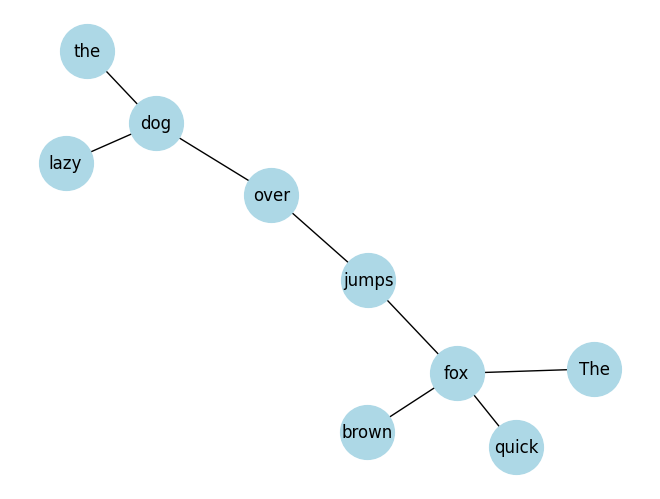

In [6]:
import networkx as nx
import matplotlib.pyplot as plt

def visualize_deps_nx(doc):
    G = nx.Graph()
    for token in doc:
        children = [child for child in token.children]
        for child in children:
            G.add_edge(token.text, child.text)
    nx.draw(G, with_labels=True, node_color='lightblue', node_size=1500, alpha=1)
    plt.show()

visualize_deps_nx(doc)

## 2.1)

In [7]:
# find root:
def get_root(doc):
    for token in doc:
        if token.head == token:
            return token
    return None
doc = nlp("The quick brown fox jumps over the lazy dog")
root = get_root(doc)
print(f"The root is: {root.text} ({root.pos_})")

The root is: jumps (VERB)


## 2.2)

In [8]:
def get_subject_object(doc):
    subjects = [t for t in doc if "subj" in t.dep_]
    objects = [t for t in doc if "obj" in t.dep_]
    return subjects, objects
subjects, objects = get_subject_object(doc)
print(f"Subjects: {[t.text for t in subjects]}")
print(f"Objects: {[t.text for t in objects]}")

Subjects: ['fox']
Objects: ['dog']


## 2.3)
The relationships we can detect using the structure found by dependency parsing can be used in various ways. One example is to apply knowledge of common structures in a langauge to verify that the next prediction would, in fact, be valid. For english, we have the typical subject-verb-object.


## 3.1)

In [9]:
from nltk.corpus import wordnet as wn
def get_synonyms(word):
    synonyms = []
    for synset in wn.synsets(word):
        synonyms.extend(synset.lemma_names())
    return sorted(list(set(synonyms)))

get_synonyms("programmer")

['coder', 'computer_programmer', 'programmer', 'software_engineer']

## 3.2)

In [10]:
from collections import defaultdict
# get more features
def get_wordnet_features(word):
    # extract all possible features from wordnet:
    features = defaultdict(list)
    for synset in wn.synsets(word):
        features["lemma_names"].extend(synset.lemma_names())
        features["definition"].append(synset.definition())
        features["hypernyms"].extend(synset.hypernyms())
        features["hyponyms"].extend(synset.hyponyms())
    return {k: set(v) for k, v in features.items()}

get_wordnet_features("programming")

{'lemma_names': {'computer_programing',
  'computer_programming',
  'program',
  'programing',
  'programme',
  'programming',
  'scheduling'},
 'definition': {'arrange a program of or for',
  'creating a sequence of instructions to enable the computer to do something',
  'setting an order and time for planned events',
  'write a computer program'},
 'hypernyms': {Synset('create_by_mental_act.v.01'),
  Synset('creating_by_mental_acts.n.01'),
  Synset('planning.n.01'),
  Synset('schedule.v.02')},
 'hyponyms': {Synset('hack.v.06'),
  Synset('logic_programming.n.02'),
  Synset('object-oriented_programming.n.01')}}

## 3.3) Sentiwordnet

In [11]:
from nltk.corpus import sentiwordnet as swn
from nltk import word_tokenize
import spacy
nlp = spacy.load("en_core_web_sm")

all_wordnet_pos_tags = ["n", "v", "a", "r"]
# n: noun, v: verb, a: adjective, r: adverb
# universal-style:
# NOUN, VERB, ADJ, ADV
universal_to_wn = {"NOUN": "n", "VERB": "v", "ADJ": "a", "ADV": "r"}
    

def get_sentiment(word, pos=None):
    if pos not in universal_to_wn.keys():
        return 0
    sentiment = 0
    if len(wn.synsets(word)) == 0:
        return sentiment # neutral
    for synset in wn.synsets(word, pos=universal_to_wn[pos]):
        ssyn = swn.senti_synset(synset.name())
        tmp_sent = ssyn.pos_score() - ssyn.neg_score()
        sentiment += tmp_sent

    avg_word_score = sentiment / len(wn.synsets(word))  # average score of all synsets
    scaling_factor = 2
    return avg_word_score * scaling_factor

def get_sentiment_from_sent(sent):
    doc = nlp(sent)
    # tokens = [token.text for token in doc]
    tagged = [(token.text, token.pos_) for token in doc if token.is_alpha]
    sentiment = sum([get_sentiment(word, tag) for (word, tag) in tagged])
    # do some smoothing, so the length doesn't matter
    # only base this on actual words, such that !!!! doesn't count as 4 extra tokens
    num_words = [w for w in tokens if w.isalpha()]
    # only count unique words
    num_words = set(num_words)
    if len(num_words) > 0:
        return sentiment / len(num_words)
    return sentiment

def readable_sentiment_output(sent, threshold=0.1):
    # experiment with threshold parameter
    sentiment = get_sentiment_from_sent(sent)
    readable = "Neutral"
    if sentiment < -threshold:
        readable = "Negative"
    elif sentiment > threshold:
        readable = "Positive"
    return f"{sent}\n-> {readable} ({round(sentiment, 4)})\n"

some_sents = [
    "Well, I don't hate it, but it's not the greatest!",
    "It's not bad, but it's not great either.",
    "It's terrible",
    "While I can't say I loved it, I can see why some people would.",
    "I don't care if you loved it - it was terrible!",
    "I don't care if you hated it, I think it was awesome"
]
for s in some_sents:
    print(readable_sentiment_output(s))


Well, I don't hate it, but it's not the greatest!
-> Neutral (0.0)

It's not bad, but it's not great either.
-> Neutral (-0.0621)

It's terrible
-> Negative (-0.1389)

While I can't say I loved it, I can see why some people would.
-> Positive (0.1168)

I don't care if you loved it - it was terrible!
-> Neutral (-0.0207)

I don't care if you hated it, I think it was awesome
-> Positive (0.1654)



# 4. Building a sentiment analysis model

In [12]:
from nltk.corpus import stopwords
from nltk.corpus import twitter_samples
import spacy
import re

STOP = stopwords.words("english")

twitter_words_to_filter = ["rt"]
def filter_single_letter(word):
    return len(word) > 1 or word == 'a' or word == 'i'

def twitter_preprocessing(tokenized_post):
    # tokenized_post = [w for w in tokenized_post if w not in STOP]
    # ignore numbers, mentions, links etc.
    pattern = re.compile(r"^[a-zA-Z\!\?\,\.\']+$")
    dot_pattern = re.compile(r"\.{2,}")
    tokens = [
        w.lower() for w in tokenized_post
        if pattern.match(w) and not dot_pattern.match(w)
        and w.lower() not in twitter_words_to_filter
        and filter_single_letter(w)
    ]
    return tokens

def get_tweets(positive=True):
    source = "positive_tweets.json" if positive else "negative_tweets.json"
    tokenized = twitter_samples.tokenized(source)
    return [" ".join(twitter_preprocessing(tweet)) for tweet in tokenized
            if len(tweet) > 3]  

positive_tweets = get_tweets(positive=True)
negative_tweets = get_tweets(positive=False)

In [13]:
data = positive_tweets + negative_tweets
labels = [1] * len(positive_tweets) + [0] * len(negative_tweets)

In [14]:
import pandas as pd
df = pd.DataFrame({"tweet": data, "label": labels})
df.to_csv("data/lab3_twitter_all.csv", index=False)

In [77]:
from sklearn.model_selection import train_test_split

def stratified_split(data, labels, test_size=0.2):
    return train_test_split(data, labels, test_size=test_size, stratify=labels)
X_train, X_test, y_train, y_test = stratified_split(data, labels)

In [78]:
train_df = pd.DataFrame({"tweet": X_train, "label": y_train})
test_df = pd.DataFrame({"tweet": X_test, "label": y_test})

train_df.to_csv("data/lab3_twitter_train.csv", index=False)
test_df.to_csv("data/lab3_twitter_test.csv", index=False)

In [79]:
from sklearn.metrics import classification_report

# use the get_sentiment_from_sent function from above
preds = []
for sent in X_test:
    sentiment = get_sentiment_from_sent(sent)
    if sentiment > 0:
        preds.append(1)
    else:
        preds.append(0)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.61      0.57      0.59       958
           1       0.60      0.65      0.62       970

    accuracy                           0.61      1928
   macro avg       0.61      0.61      0.61      1928
weighted avg       0.61      0.61      0.61      1928



In [80]:
# use scikit-learn to normalize, vectorize/extract features and train a classifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier

pipe = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB()),
])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.77      0.76       958
           1       0.77      0.75      0.76       970

    accuracy                           0.76      1928
   macro avg       0.76      0.76      0.76      1928
weighted avg       0.76      0.76      0.76      1928

